# Intro to Object Detection Colab

Welcome to the object detection colab! This demo will take you through the steps of running an "out-of-the-box" detection model in SavedModel format on a collection of images.



Imports

In [7]:
import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils
import importlib

%matplotlib inline

In [2]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load the COCO Label Map
category_index = {
    1: {'id': 1, 'name': 'car'},
    2: {'id': 2, 'name': 'van'},
    3: {'id': 3, 'name': 'bus'},
    4: {'id': 4, 'name': 'others'},
}

In [3]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('/home/ubuntu/ibrahim/master/training/od_detrac_ssd_mnv2_300/saved_model/saved_model/')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

2022-01-05 00:51:18.771666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/openvino_2020.3.341/opencv/lib:/opt/intel/openvino_2020.3.341/deployment_tools/ngraph/lib:/opt/intel/openvino_2020.3.341/deployment_tools/inference_engine/external/hddl/lib:/opt/intel/openvino_2020.3.341/deployment_tools/inference_engine/external/gna/lib:/opt/intel/openvino_2020.3.341/deployment_tools/inference_engine/external/mkltiny_lnx/lib:/opt/intel/openvino_2020.3.341/deployment_tools/inference_engine/external/tbb/lib:/opt/intel/openvino_2020.3.341/deployment_tools/inference_engine/lib/intel64:/home/ubuntu/torch/install/lib:/usr/local/cuda-10.0/lib64/
2022-01-05 00:51:18.774960: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are 

Elapsed time: 25.450077056884766s


# Test Single Image

In [ ]:
import time

image_dir = '/home/ubuntu/ibrahim/master/models/research/object_detection/test_images'

elapsed = []
for i in range(2):
  image_path = os.path.join(image_dir, 'img' + str(i + 1) + '.jpg')
  image_np = load_image_into_numpy_array(image_path)
  print(image_np.shape)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  print(detections['detection_boxes'][0])
  print(detections['detection_classes'][0])
  print(detections['detection_scores'][0])
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.5,
        agnostic_mode=False)
  plt.subplot(2, 1, i+1)
  plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

# Test SORT

In [4]:
import object_detection.tracking.sort.sort
from object_detection.tracking.sort.sort import Sort
np.set_printoptions(precision=3)

In [5]:
def draw_sort(image, track_bbs_ids):
    image_pil=Image.fromarray(np.uint8(image)).convert('RGB')
    draw = ImageDraw.Draw(image_pil)
    im_width, im_height = image_pil.size
    for det in track_bbs_ids:
        (left, right, top, bottom) = (det[0], det[2], det[1], det[3])
        draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=4, fill='red')
        draw.text((left + 10, bottom - 10),
                    'ID: '+str(det[4]),
                    fill='green')
    np.copyto(image, np.array(image_pil))

In [ ]:
import time

image_dir = '/home/ubuntu/ibrahim/master/models/research/object_detection/test_images'

elapsed = []
th = 0.5
importlib.reload(object_detection.tracking.sort.sort)
mot_tracker= Sort()
for i in range(2):
  image_path = os.path.join(image_dir, 'img' + str(i + 1) + '.jpg')
  image_np = load_image_into_numpy_array(image_path)
  height, width, _ = image_np.shape
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  boxes = detections['detection_boxes'][0].numpy()
  classes = detections['detection_classes'][0].numpy().astype(np.int32)
  scores = detections['detection_scores'][0].numpy()
  det = []
  for f in range(boxes.shape[0]):
    box = boxes[f]
    if scores[f] > th:
        box_top = int(box[0] * height)
        box_left = int(box[1] * width)
        box_bottom = int(box[2] * height)
        box_right = int(box[3] * width)
        det.append([box_left, box_top, box_right, box_bottom, scores[f], classes[f]])
  track_bbs_ids = mot_tracker.update(np.array(det))
  end_time = time.time()
  elapsed.append(end_time - start_time)
  print(track_bbs_ids)
  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  draw_sort(image_np_with_detections, track_bbs_ids)
  plt.subplot(2, 1, i+1)
  plt.imshow(image_np_with_detections)
mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

# SORT Generate MOT Challenge Predections

In [18]:
import time
from tqdm import notebook


DETRAC_TEST = '/home/ubuntu/ibrahim/master/datasets/Insight-MVT_Annotation_Test'

elapsed = []
th = 0.5

for directory in notebook.tqdm(sorted(os.listdir(DETRAC_TEST))):
    if os.path.isdir(os.path.join(DETRAC_TEST, directory)):
        importlib.reload(object_detection.tracking.sort.sort)
        mot_tracker= Sort()
        prediticon_file = open(os.path.join('/home/ubuntu/ibrahim/master/training/od_detrac_ssd_mnv2_300/sort/', directory + "_Prediction.txt"), "w")
        for image in notebook.tqdm(sorted(os.listdir(os.path.join(DETRAC_TEST, directory)))):
            image_path = os.path.join(DETRAC_TEST, directory, image)
            frame_no = int(image.replace('img', '').replace('.jpg', ''))
            image_np = load_image_into_numpy_array(image_path)
            height, width, _ = image_np.shape
            input_tensor = np.expand_dims(image_np, 0)
            start_time = time.time()
            detections = detect_fn(input_tensor)
            end_time = time.time()
            elapsed.append(end_time - start_time)
            boxes = detections['detection_boxes'][0].numpy()
            classes = detections['detection_classes'][0].numpy().astype(np.int32)
            scores = detections['detection_scores'][0].numpy()
            det = []
            for f in range(boxes.shape[0]):
                box = boxes[f]
                if scores[f] > th:
                    box_top = int(box[0] * height)
                    box_left = int(box[1] * width)
                    box_bottom = int(box[2] * height)
                    box_right = int(box[3] * width)
                    det.append([box_left, box_top, box_right, box_bottom, scores[f], classes[f]])
            if det:
                track_bbs_ids = mot_tracker.update(np.array(det))
            else:
                track_bbs_ids = mot_tracker.update()
            for track_pred in track_bbs_ids:
                bb_w = track_pred[2] - track_pred[0]
                bb_h = track_pred[3] - track_pred[1]
                prediticon_file.write(f'{frame_no}, {int(track_pred[4])}, {track_pred[0]:.2f}, {track_pred[1]:.2f}, {bb_w:.2f}, {bb_h:.2f}, 1, -1, -1, -1 \n')
        prediticon_file.close()
mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1470 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1660 [00:00<?, ?it/s]

  0%|          | 0/1570 [00:00<?, ?it/s]

  0%|          | 0/1505 [00:00<?, ?it/s]

  0%|          | 0/2030 [00:00<?, ?it/s]

  0%|          | 0/1390 [00:00<?, ?it/s]

  0%|          | 0/1385 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/1130 [00:00<?, ?it/s]

  0%|          | 0/1030 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/1180 [00:00<?, ?it/s]

  0%|          | 0/1655 [00:00<?, ?it/s]

  0%|          | 0/1630 [00:00<?, ?it/s]

  0%|          | 0/2030 [00:00<?, ?it/s]

  0%|          | 0/1825 [00:00<?, ?it/s]

  0%|          | 0/1745 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/1810 [00:00<?, ?it/s]

  0%|          | 0/1960 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/1670 [00:00<?, ?it/s]

  0%|          | 0/1515 [00:00<?, ?it/s]

  0%|          | 0/1545 [00:00<?, ?it/s]

  0%|          | 0/1790 [00:00<?, ?it/s]

  0%|          | 0/1335 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1060 [00:00<?, ?it/s]

  0%|          | 0/1270 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

Elapsed time: 0.051701351616202325 second per image


# Deep SORT Generate MOT Challenge Predections

In [4]:
from object_detection.tracking.deep_sort.deep_sort import nn_matching
from object_detection.tracking.deep_sort.deep_sort.detection import Detection
import object_detection.tracking.deep_sort.deep_sort.tracker
from object_detection.tracking.deep_sort.deep_sort.tracker import Tracker
from object_detection.tracking.deep_sort.tools import generate_detections as gdet

In [5]:
model_filename = '/home/ubuntu/ibrahim/master/models/research/object_detection/tracking/deep_sort/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

# Test 3 images

[<object_detection.tracking.deep_sort.deep_sort.detection.Detection object at 0x7f436841f150>, <object_detection.tracking.deep_sort.deep_sort.detection.Detection object at 0x7f4348aa9e10>, <object_detection.tracking.deep_sort.deep_sort.detection.Detection object at 0x7f4348aa9fd0>, <object_detection.tracking.deep_sort.deep_sort.detection.Detection object at 0x7f44f810d550>, <object_detection.tracking.deep_sort.deep_sort.detection.Detection object at 0x7f43781bd210>, <object_detection.tracking.deep_sort.deep_sort.detection.Detection object at 0x7f43781bd8d0>, <object_detection.tracking.deep_sort.deep_sort.detection.Detection object at 0x7f43781bd4d0>, <object_detection.tracking.deep_sort.deep_sort.detection.Detection object at 0x7f43781bdc10>, <object_detection.tracking.deep_sort.deep_sort.detection.Detection object at 0x7f43781bd2d0>, <object_detection.tracking.deep_sort.deep_sort.detection.Detection object at 0x7f43781bdb10>]
[]
[<object_detection.tracking.deep_sort.deep_sort.detectio

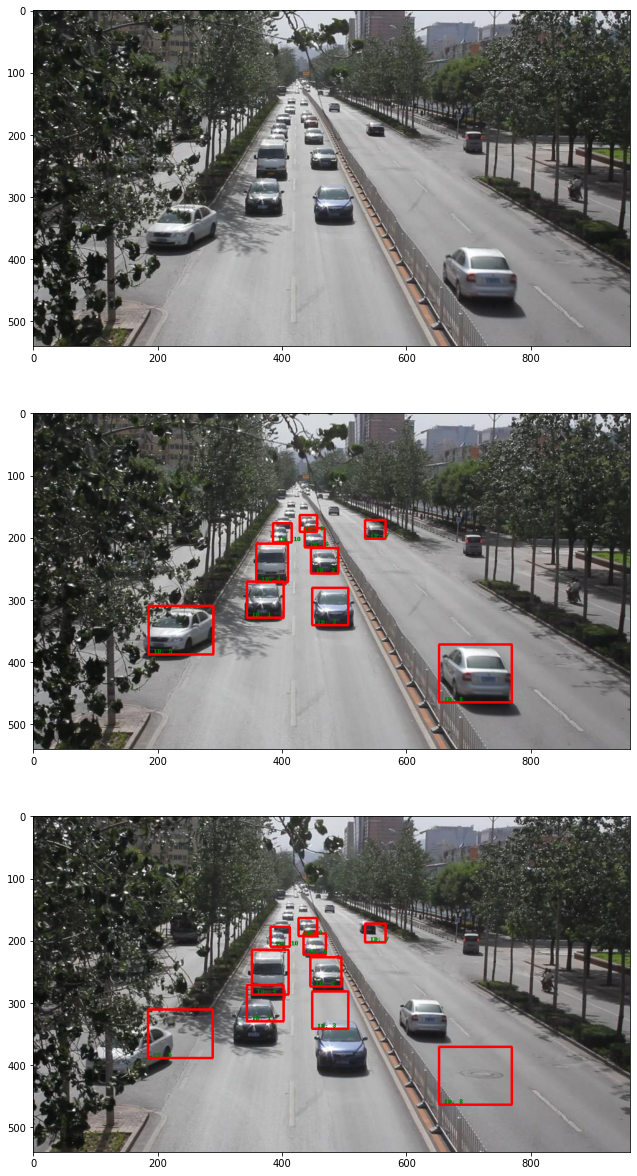

In [10]:
import time

image_dir = '/home/ubuntu/ibrahim/master/models/research/object_detection/test_images'

elapsed = []
th = 0.5
importlib.reload(object_detection.tracking.deep_sort.deep_sort.tracker)

deep_tracker = Tracker(nn_matching.NearestNeighborDistanceMetric("euclidean", 0.3, 10))
for i in range(3):
  image_path = os.path.join(image_dir, 'img' + str(i + 1) + '.jpg')
  image_np = load_image_into_numpy_array(image_path)
  height, width, _ = image_np.shape
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  boxes = detections['detection_boxes'][0].numpy()
  classes = detections['detection_classes'][0].numpy().astype(np.int32)
  scores = detections['detection_scores'][0].numpy()
  det = []
  for f in range(boxes.shape[0]):
    box = boxes[f]
    if scores[f] > th:
        box_top = int(box[0] * height)
        box_left = int(box[1] * width)
        box_bottom = int(box[2] * height)
        box_right = int(box[3] * width)
        det.append([box_left, box_top, (box_right-box_left), (box_bottom-box_top), scores[f], classes[f]])
  features = encoder(image_np, np.array(det)[:, 0:4])
  detections = [Detection((bbox[0], bbox[1], bbox[2], bbox[3]), bbox[4], feature)
                                for bbox, feature in zip(det, features)]
  print(detections)
  deep_tracker.predict()
  deep_tracker.update(detections)
  end_time = time.time()
  elapsed.append(end_time - start_time)
  track_bbs_ids = []
  for track in deep_tracker.tracks:
    if not track.is_confirmed() or track.time_since_update > 1:
      continue
    track_bbs_ids.append([*track.to_tlbr(), track.track_id])
  print(track_bbs_ids)
  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  draw_sort(image_np_with_detections, track_bbs_ids)
  plt.subplot(3, 1, i+1)
  plt.imshow(image_np_with_detections)
mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

In [8]:
import time
from tqdm import notebook


DETRAC_TEST = '/home/ubuntu/ibrahim/master/datasets/Insight-MVT_Annotation_Test'

elapsed = []
th = 0.5

for directory in notebook.tqdm(sorted(os.listdir(DETRAC_TEST))):
    if os.path.isdir(os.path.join(DETRAC_TEST, directory)):
        importlib.reload(object_detection.tracking.deep_sort.deep_sort.tracker)
        deep_tracker = Tracker(nn_matching.NearestNeighborDistanceMetric("cosine", 0.3, None))
        prediticon_file = open(os.path.join('/home/ubuntu/ibrahim/master/training/od_detrac_ssd_mnv2_300/deep_sort/', directory + ".txt"), "w")
        for image in notebook.tqdm(sorted(os.listdir(os.path.join(DETRAC_TEST, directory)))):
            image_path = os.path.join(DETRAC_TEST, directory, image)
            frame_no = int(image.replace('img', '').replace('.jpg', ''))
            image_np = load_image_into_numpy_array(image_path)
            height, width, _ = image_np.shape
            input_tensor = np.expand_dims(image_np, 0)
            start_time = time.time()
            detections = detect_fn(input_tensor)
            end_time = time.time()
            elapsed.append(end_time - start_time)
            boxes = detections['detection_boxes'][0].numpy()
            classes = detections['detection_classes'][0].numpy().astype(np.int32)
            scores = detections['detection_scores'][0].numpy()
            det = []
            for f in range(boxes.shape[0]):
                box = boxes[f]
                if scores[f] > th:
                    box_top = int(box[0] * height)
                    box_left = int(box[1] * width)
                    box_bottom = int(box[2] * height)
                    box_right = int(box[3] * width)
                    det.append([box_left, box_top, (box_right-box_left), (box_bottom-box_top), scores[f], classes[f]])
            if det:
                features = encoder(image_np, np.array(det)[:, 0:4])
            else:
                features = encoder(image_np, np.array(det))
            detections = [Detection((bbox[0], bbox[1], bbox[2], bbox[3]), bbox[4], feature)
                                    for bbox, feature in zip(det, features)]
            deep_tracker.predict()
            deep_tracker.update(detections)
            track_bbs_ids = []
            for track in deep_tracker.tracks:
                if not track.is_confirmed() or track.time_since_update > 1:
                    continue
                track_bbs_ids.append([*track.to_tlbr(), track.track_id])
            for track_pred in track_bbs_ids:
                bb_w = track_pred[2] - track_pred[0]
                bb_h = track_pred[3] - track_pred[1]
                prediticon_file.write(f'{frame_no}, {int(track_pred[4])}, {track_pred[0]:.2f}, {track_pred[1]:.2f}, {bb_w:.2f}, {bb_h:.2f}, 1, -1, -1, -1 \n')
        prediticon_file.close()
mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1470 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1660 [00:00<?, ?it/s]

  0%|          | 0/1570 [00:00<?, ?it/s]

  0%|          | 0/1505 [00:00<?, ?it/s]

  0%|          | 0/2030 [00:00<?, ?it/s]

  0%|          | 0/1390 [00:00<?, ?it/s]

  0%|          | 0/1385 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/1130 [00:00<?, ?it/s]

  0%|          | 0/1030 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/1180 [00:00<?, ?it/s]

  0%|          | 0/1655 [00:00<?, ?it/s]

  0%|          | 0/1630 [00:00<?, ?it/s]

  0%|          | 0/2030 [00:00<?, ?it/s]

  0%|          | 0/1825 [00:00<?, ?it/s]

  0%|          | 0/1745 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/1810 [00:00<?, ?it/s]

  0%|          | 0/1960 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/1670 [00:00<?, ?it/s]

  0%|          | 0/1515 [00:00<?, ?it/s]

  0%|          | 0/1545 [00:00<?, ?it/s]

  0%|          | 0/1790 [00:00<?, ?it/s]

  0%|          | 0/1335 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1060 [00:00<?, ?it/s]

  0%|          | 0/1270 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

Elapsed time: 0.0481912035869291 second per image
